In [0]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import copy

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2019-03-09 11:20:59--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.151.156, 13.32.151.36, 13.32.151.218, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.151.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  35.8MB/s    in 1.3s    

2019-03-09 11:21:06 (35.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [17]:
!ls

hymenoptera_data  hymenoptera_data.zip	sample_data


In [5]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [6]:
!ls

hymenoptera_data  hymenoptera_data.zip	sample_data


In [7]:
%cd hymenoptera_data

/content/hymenoptera_data


In [8]:
!ls

train  val


In [9]:
%cd ..

/content


In [0]:
model_list = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']

In [0]:
data_dir = './hymenoptera_data'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = model_list[0] # resnet 

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
  
  since = time.time()
  
  val_acc_history = []
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0
  
  for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} / {num_epochs}')
    print('-' * 15)
    
    # each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode
      
      running_loss = 0
      running_corrects = 0
      
      # iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero parameters grads
        optimizer.zero_grad()
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          # Special case for inception because in training it has an auxiliary output. In train
          #   mode we calculate the loss by summing the final output and the auxiliary output
          #   but in testing we only consider the final output.
          if is_inception and phase == 'train':
            outputs, aux_outputs = model(inputs)
            loss_1 = criterion(outputs, labels)
            loss_2 = criterion(aux_outputs, labels)
            loss = loss_1 + 0.4*loss_2
          else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
          
          _, preds = torch.max(outputs, 1)
          
          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
          # statistics
          running_loss += loss
          running_corrects += torch.sum(preds == labels)
          
        
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
      print(f'Phase : {phase} <> Loss : {epoch_loss} <> Acc : {epoch_acc}')
        
      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
      if phase == 'val':
        val_acc_history.append(epoch_acc)
        
    # end epoch's FOR cycle
    print()
    
  time_elapsed = time.time() - since
  print(f'Training complite in {time_elapsed / 60} m and {time_elapsed % 60} sec')
  print(f'Best Validation accuracy - {best_acc}')
  
  # load best model weights
  model.load_state_dict(best_model_wts)
  
  return model, val_acc_history


In [0]:
def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  
  # Initialize these variables which will be set in this if statements
  model_tf = None
  input_size= ()
  
  if model_name == 'resnet':
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  
  elif model_name == 'alexnet':
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_tfrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
  elif model_name == 'vgg':
    model_ft = models.vgg11_bn(pretrained=use_pretraind)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ftrs.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  
  elif model_name =='squeeznet':
    model_ft = models.squeezenet1_1(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
  elif model_name == 'densenet':
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
  elif model_name == 'inception':
    model_ft = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs_aux = model_ft.AuxLogits.fc.in_features
    model_tf.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 299
    
  else:
    print('Invalid model name. Exiting ...')
    exit()
    
  return model_ft, input_size

In [0]:
# Initialize the model for this run

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

## **Notice, the models were pretrained with the hard-coded normalization values**

In [24]:
import os
# Data augmentation and normalization for training
# Just normalization for validation

data_transformers = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size), # we don't need resize, this function will do it
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),             # we don't need resize, but in tutorial it was, so this is why i useit
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transformers[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True) 
                    for x in ['train', 'val']
                   }

Initializing Datasets and Dataloaders...


In [0]:
# Send the model to GPU
model_ft = model_ft.to(device)

### **To verify this, check out the printed parameters to learn. When finetuning, this list should be long and include all of the model parameters. However, when feature extracting this list should be short and only include the weights and biases of the reshaped layers.**



In [31]:
#  Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True (it's DEFAULT to newly created params).

print('Params to learn: \n')

if feature_extract:
  params_to_update = []
  
  for name, param in model_ft.named_parameters():
  
    if param.requires_grad == True:
      params_to_update.append(param)
      print('\t', name)
    
else:
  for name, param in model_ft.named_parameters():
    
    if param.requires_grad == True:
      print('\t', name)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update)

Params to learn: 

	 fc.weight
	 fc.bias


In [34]:
# Setup the loss func
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, acc_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=25, is_inception=False)

Epoch 1 / 25
---------------
Phase : train <> Loss : 0.011631476692855358 <> Acc : 0.5655737704918034
Phase : val <> Loss : 0.011564647778868675 <> Acc : 0.6601307189542484

Epoch 2 / 25
---------------
Phase : train <> Loss : 0.009306407533586025 <> Acc : 0.7213114754098361
Phase : val <> Loss : 0.008627941831946373 <> Acc : 0.8431372549019608

Epoch 3 / 25
---------------
Phase : train <> Loss : 0.007668319623917341 <> Acc : 0.8155737704918034
Phase : val <> Loss : 0.007335061207413673 <> Acc : 0.869281045751634

Epoch 4 / 25
---------------
Phase : train <> Loss : 0.006270083598792553 <> Acc : 0.8606557377049181
Phase : val <> Loss : 0.006121453829109669 <> Acc : 0.888888888888889

Epoch 5 / 25
---------------
Phase : train <> Loss : 0.005499039310961962 <> Acc : 0.889344262295082
Phase : val <> Loss : 0.005710584577172995 <> Acc : 0.9215686274509804

Epoch 6 / 25
---------------
Phase : train <> Loss : 0.005301815457642078 <> Acc : 0.8811475409836066
Phase : val <> Loss : 0.0052205

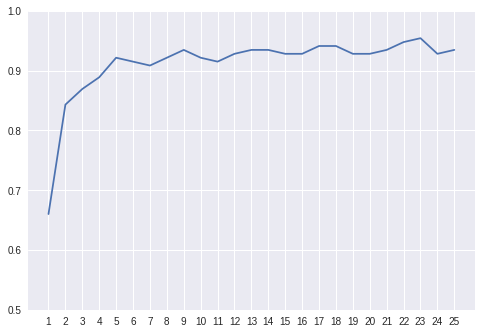

In [42]:
import numpy as np

plt.plot(range(1,25+1), acc_hist, label="Pretrained")
plt.ylim((0.5, 1.))
plt.xticks(np.arange(1, 25+1, 1.0))
plt.show()